[Reference](https://towardsdatascience.com/multiple-imputation-with-random-forests-in-python-dec83c0ac55b)

In [1]:
!pip install miceforest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.8 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [2]:
import miceforest as mf
from sklearn.datasets import load_iris
import pandas as pd

# Load and format data
iris = pd.concat(load_iris(as_frame=True,return_X_y=True),axis=1)
iris.rename(columns = {'target':'species'}, inplace = True)
iris['species'] = iris['species'].astype('category')

# Introduce missing values
iris_amp = mf.ampute_data(iris,perc=0.25,random_state=1991)

In [3]:
# Create kernels. 
kernel = mf.ImputationKernel(
  data=iris_amp,
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(3,verbose=True)

Initialized logger with name mice 1-3
Dataset 0
1  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm) | species
2  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm) | species
3  | sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm) | species


In [4]:
kernel.plot_correlations(wspace=0.4,hspace=0.5)

ValueError: ignored

In [5]:
# Our new dataset
new_data = iris_amp.iloc[range(50)]
# Make a multiple imputed dataset with our new data
new_data_imputed = kernel.impute_new_data(new_data)
# Return a completed dataset
new_completed_data = new_data_imputed.complete_data(0)

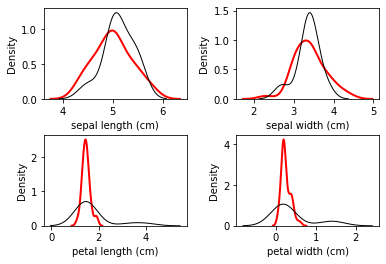

In [6]:
new_data_imputed.plot_imputed_distributions(wspace=0.35,hspace=0.4)

<ipython-input-7-86738aea9434>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X, y = comp_dat.drop(target,1), comp_dat[target]


Text(0.5, 1.0, '\n    Assumed Distribution of Intercept Term\n    n=5, mean = 1.39, variance = 0.0\n    ')

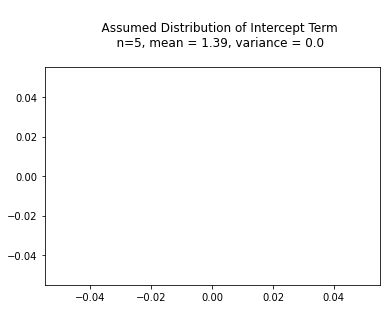

In [7]:
from sklearn.linear_model import LinearRegression
# For each imputed dataset, train a linear regression
# on 'sepal length (cm)'
intercepts = []
target = 'sepal length (cm)'
for d in range(kernel.dataset_count()):
    comp_dat = kernel.complete_data(d)
    comp_dat = pd.get_dummies(comp_dat)
    X, y = comp_dat.drop(target,1), comp_dat[target]
    model = LinearRegression()
    model.fit(X,y)
    intercepts.append(model.intercept_)
# Load packages for plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Make plot.
avg_intercept = round(np.mean(intercepts),2)
var_intercept = round(np.var(intercepts),4)
x_axis = np.arange(
    avg_intercept - 3 * var_intercept,
    avg_intercept + 3 * var_intercept,
    0.0001
)
plt.plot(
    x_axis,
    norm.pdf(x_axis,avg_intercept,var_intercept)
)
plt.title(f"""
    Assumed Distribution of Intercept Term
    n=5, mean = {avg_intercept}, variance = {var_intercept}
    """
)